# scikit-FIBERS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-FIBERS.

***
## Imports:

In [12]:
import os
import sys
sys.path.append('../')
current_working_directory = os.getcwd()
print(current_working_directory)
PATH = os.environ['PATH']
print(PATH)

/Users/harshbandhey/Local/Cedars/Urbslab/scikit-FIBERS-1/paper_analysis_codes
/Users/harshbandhey/opt/anaconda3/envs/skfibers/bin:/Users/harshbandhey/opt/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin


In [13]:

import pickle
from sklearn.metrics import classification_report
from src.skfibersv2.fibers import FIBERS
#from src.skfibersv2.experiments.survival_sim_simple import survival_data_simulation
from src.skfibersv2.experiments.survival_covariates_sim import survival_data_simulation_covariates


***
## Set Up Local Run Parameters


In [14]:
local_save = False
folder_path = '../output/FIBERS_output'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_folder = 'local_output'
else:
    output_folder = folder_path

#Turns off comprehensive cox analysis over all bins and generation of respective figures
quick_run = True

***
## Generate Simulated Survial Data

In [15]:
data_name = 'example_dataset_covariates'
df, data = survival_data_simulation_covariates(instances=10000, total_features=100,predictive_features=5,feature_frequency_range=(0.3, 0.3), random_seed=42)
df.to_csv(output_folder+'/'+data_name+'.csv', index=False)
#data = pd.read_csv(output_folder+'/'+data_name+'.csv')
#true_risk_group = data[['TrueRiskGroup']]
#data = data.drop('TrueRiskGroup', axis=1)

#value_counts = true_risk_group['TrueRiskGroup'].value_counts()
#print(value_counts)

covariates = ['C_1','C_2'] 

***
## Run FIBERS (Training)

In [16]:
#pop_clean = 'group_strata'
fibers = FIBERS(outcome_label="Duration", outcome_type="survival", iterations=50, pop_size=50, tournament_prop=0.2, crossover_prob=0.5, min_mutation_prob=0.1, max_mutation_prob=0.5, merge_prob=0.1, 
                new_gen=1.0, elitism=0.1, diversity_pressure=0, min_bin_size=1, max_bin_size=None, max_bin_init_size=10, fitness_metric="log_rank_residuals", log_rank_weighting=None, censor_label="Censoring", 
                group_strata_min=0.2, penalty=0.5, group_thresh=None, min_thresh=0, max_thresh=5, int_thresh=True, thresh_evolve_prob=0.5, manual_bin_init=None, covariates=covariates, pop_clean = None,  
                report=[0,10,20,30,40], random_seed=42, verbose=False)
fibers = fibers.fit(data)

Dropped 0 invariant feature columns.
Iteration 1: norm_delta = 9.12e-01, step_size = 0.9500, log_lik = -74218.29762, newton_decrement = 2.64e+03, seconds_since_start = 0.3
Iteration 2: norm_delta = 9.90e-02, step_size = 0.9500, log_lik = -71509.25777, newton_decrement = 2.78e+01, seconds_since_start = 0.5
Iteration 3: norm_delta = 5.78e-03, step_size = 0.9500, log_lik = -71481.37356, newton_decrement = 9.33e-02, seconds_since_start = 0.8
Iteration 4: norm_delta = 2.88e-06, step_size = 1.0000, log_lik = -71481.28019, newton_decrement = 2.32e-08, seconds_since_start = 1.1
Convergence success after 4 iterations.
                                         feature_list  group_threshold  \
0                                         [P_4, R_89]                0   
1                  [P_1, P_3, R_23, R_24, R_65, R_70]                1   
2   [P_4, P_5, R_22, R_24, R_49, R_59, R_6, R_70, ...                2   
3                      [PC_1, R_10, R_53, R_63, R_88]                0   
4            

  0%|          | 0/50 [00:00<?, ?it/s]

### Report Run Time

In [ ]:
# Report run time
print(fibers.elapsed_time)

80.9943470954895


***
## Top (or Target) Bin Examination
### Specify Bin to Examine

In [ ]:
bin_index = 0 # lowest index is the bin with the highest fitness (only reports the bin ranked at the top, despite possible fitness ties for top)

### Get Bin Details

In [ ]:
fibers.get_bin_report(bin_index)

,0
Features in Bin:,"[P_1, P_2, P_3, P_4, P_5]"
Threshold:,1
Fitness,1.0
Pre-Fitness:,84297.31559
Log-Rank Score:,1591.575241
Log-Rank p-value:,0.0
Bin Size:,5
Group Ratio:,0.4678
Count At/Below Threshold:,5322
Count Above Threshold:,4678


### Plot: Kaplan Meier Survival Curves For Each Group Defined by the Target Bin

Dropped 0 invariant feature columns.


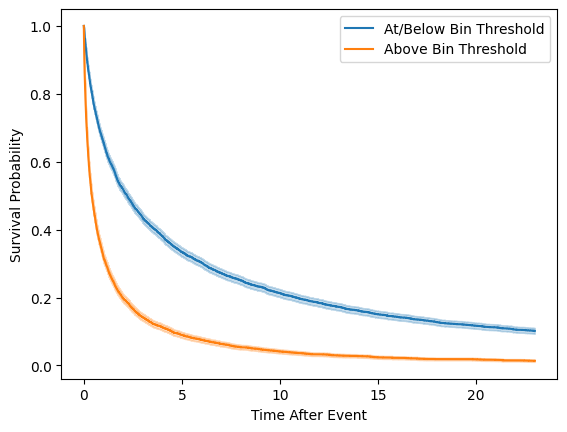

In [ ]:
fibers.get_kaplan_meir(data,bin_index,save=True,output_folder=output_folder,data_name=data_name)

### Evaluate Target Bin Using Cox Proportional Hazard Model (adjusting for covariates)

In [ ]:
summary = fibers.get_cox_prop_hazard(data, bin_index=bin_index)
bin_hr = summary['exp(coef)'].iloc[0]
bin_low_CI = summary['exp(coef) lower 95%'].iloc[0]
bin_upper_CI = summary['exp(coef) upper 95%'].iloc[0]
bin_p_val = summary['p'].iloc[0]
print("Bin HR: "+str(bin_hr)+" ("+str(bin_low_CI)+"-"+str(bin_upper_CI)+")")
print("Bin HR p-value: "+str(bin_p_val))
summary.to_csv(output_folder+'/'+'Cox_PH_adj'+str(bin_index)+'_'+data_name+'.csv', index=False)
summary

Dropped 0 invariant feature columns.
Bin HR: 4.335615035616056 (4.134548991752541-4.546459063505293)
Bin HR p-value: 0.0


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Bin_0,1.466863,4.335615,0.024228,1.419378,1.514349,4.134549,4.546459,0.0,60.545139,0.0,inf
C_1,0.865614,2.376466,0.012713,0.840697,0.890532,2.317983,2.436425,0.0,68.088481,0.0,inf
C_2,0.864983,2.374966,0.012887,0.839726,0.890241,2.315732,2.435716,0.0,67.121918,0.0,inf


### Check and View Any Top Bin Ties

In [ ]:
fibers.report_ties()

Only one top performing bin found


***
## Bin Population Examination
### Plot: Basic Bin Population Heatmap

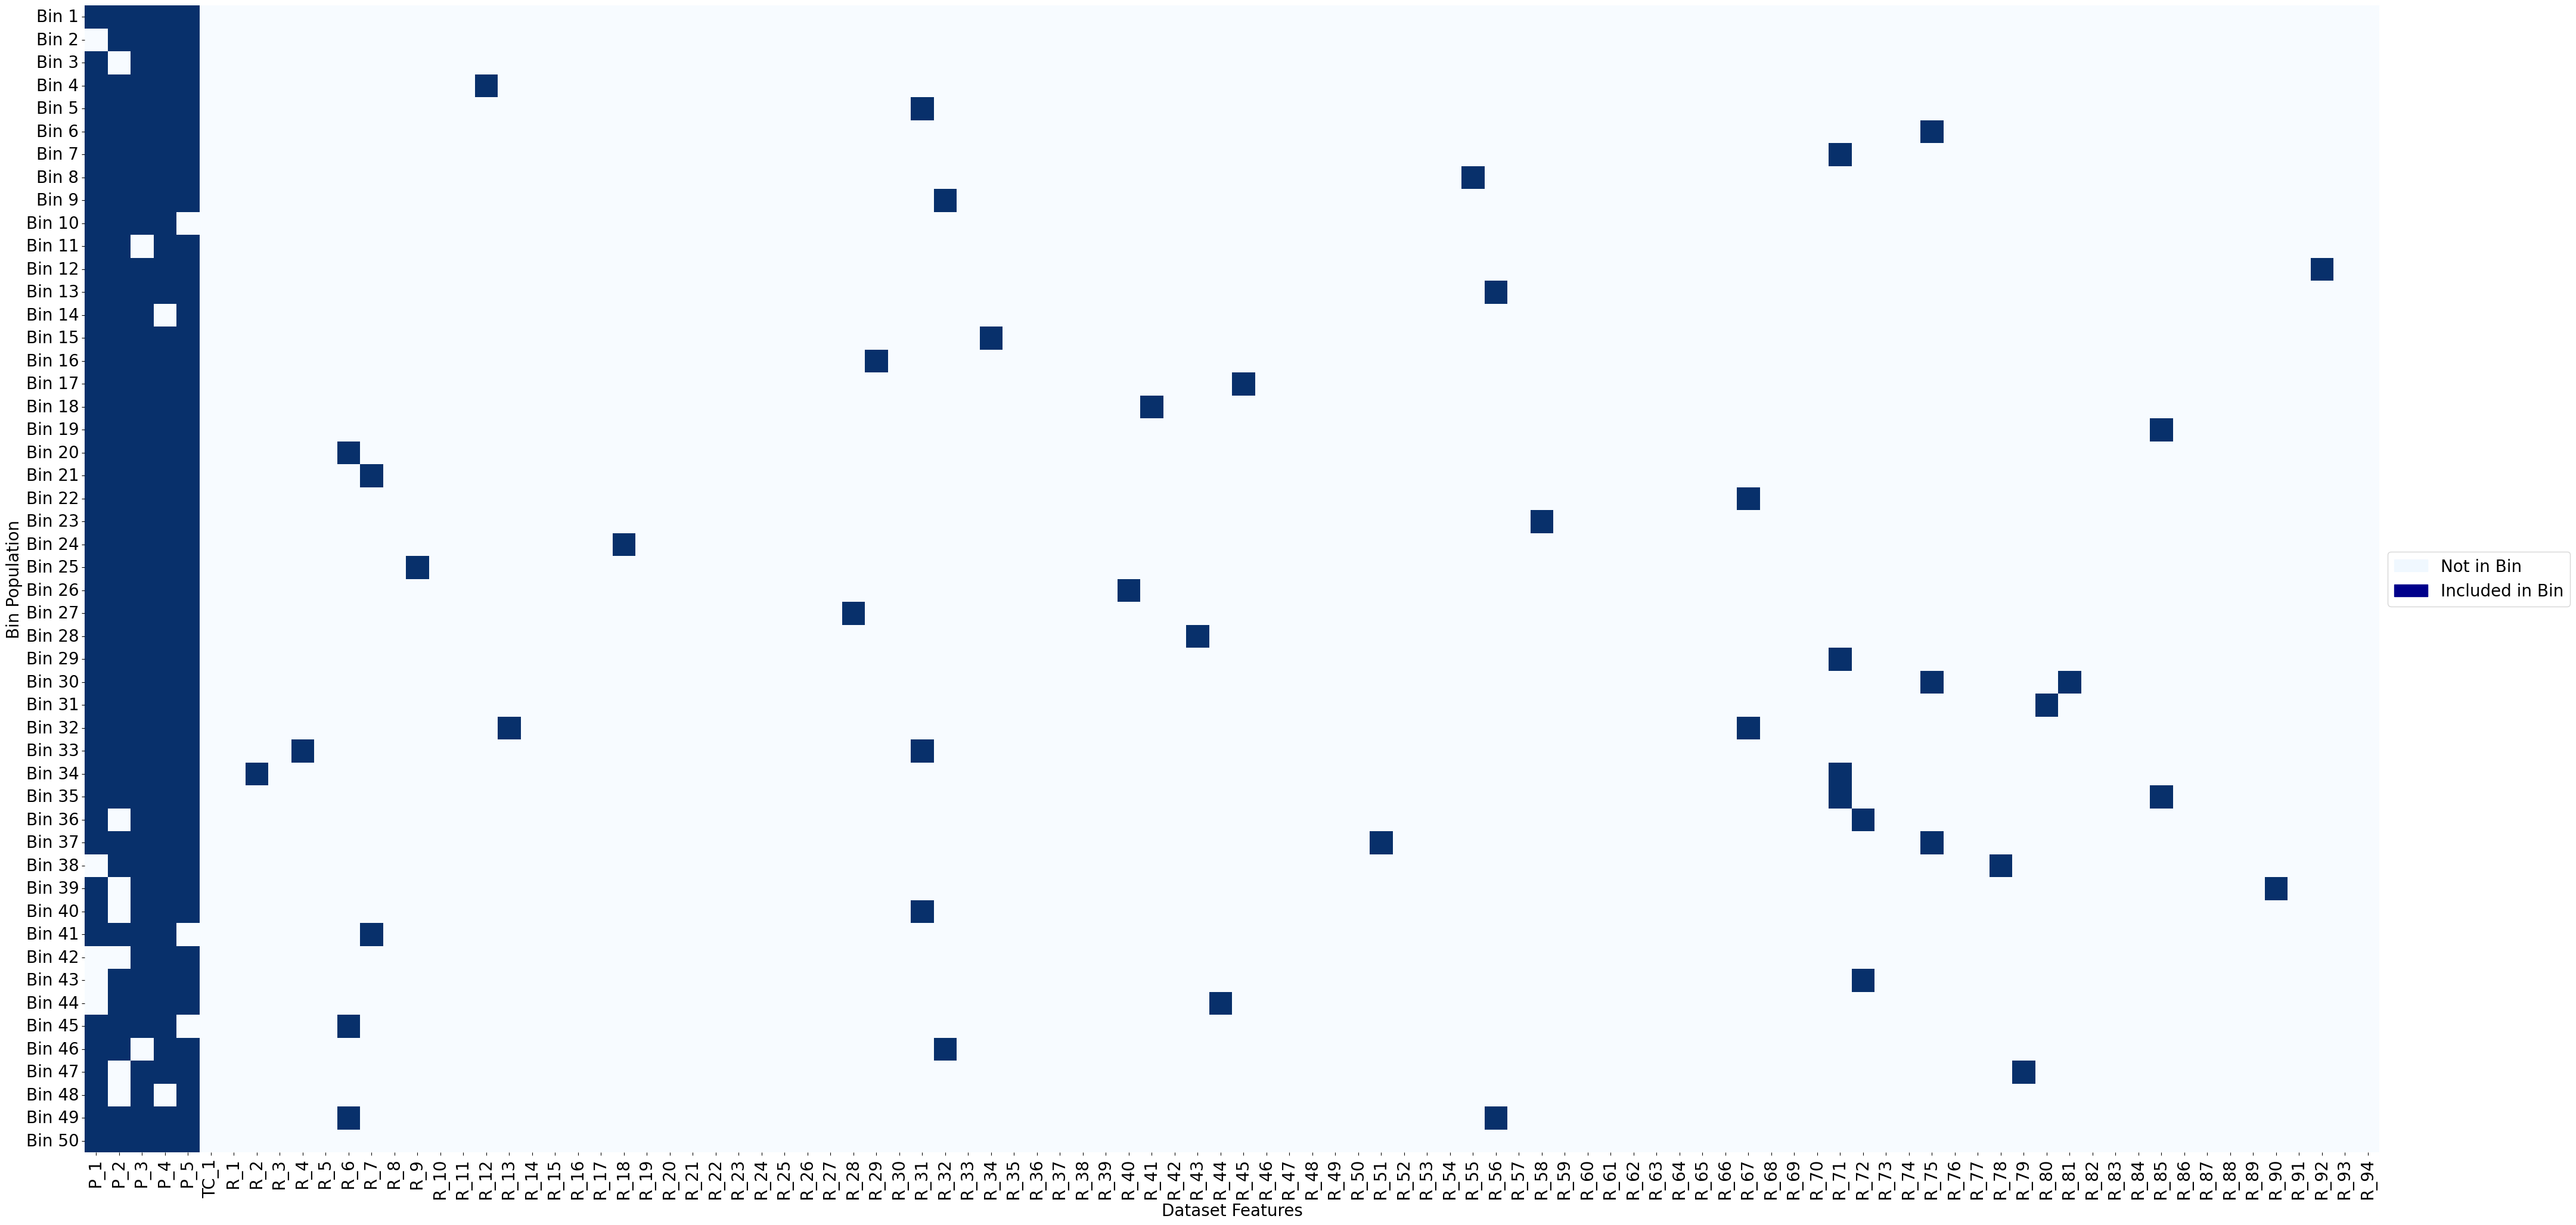

In [ ]:
fibers.get_bin_population_heatmap_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Custom Bin Population Heatmap

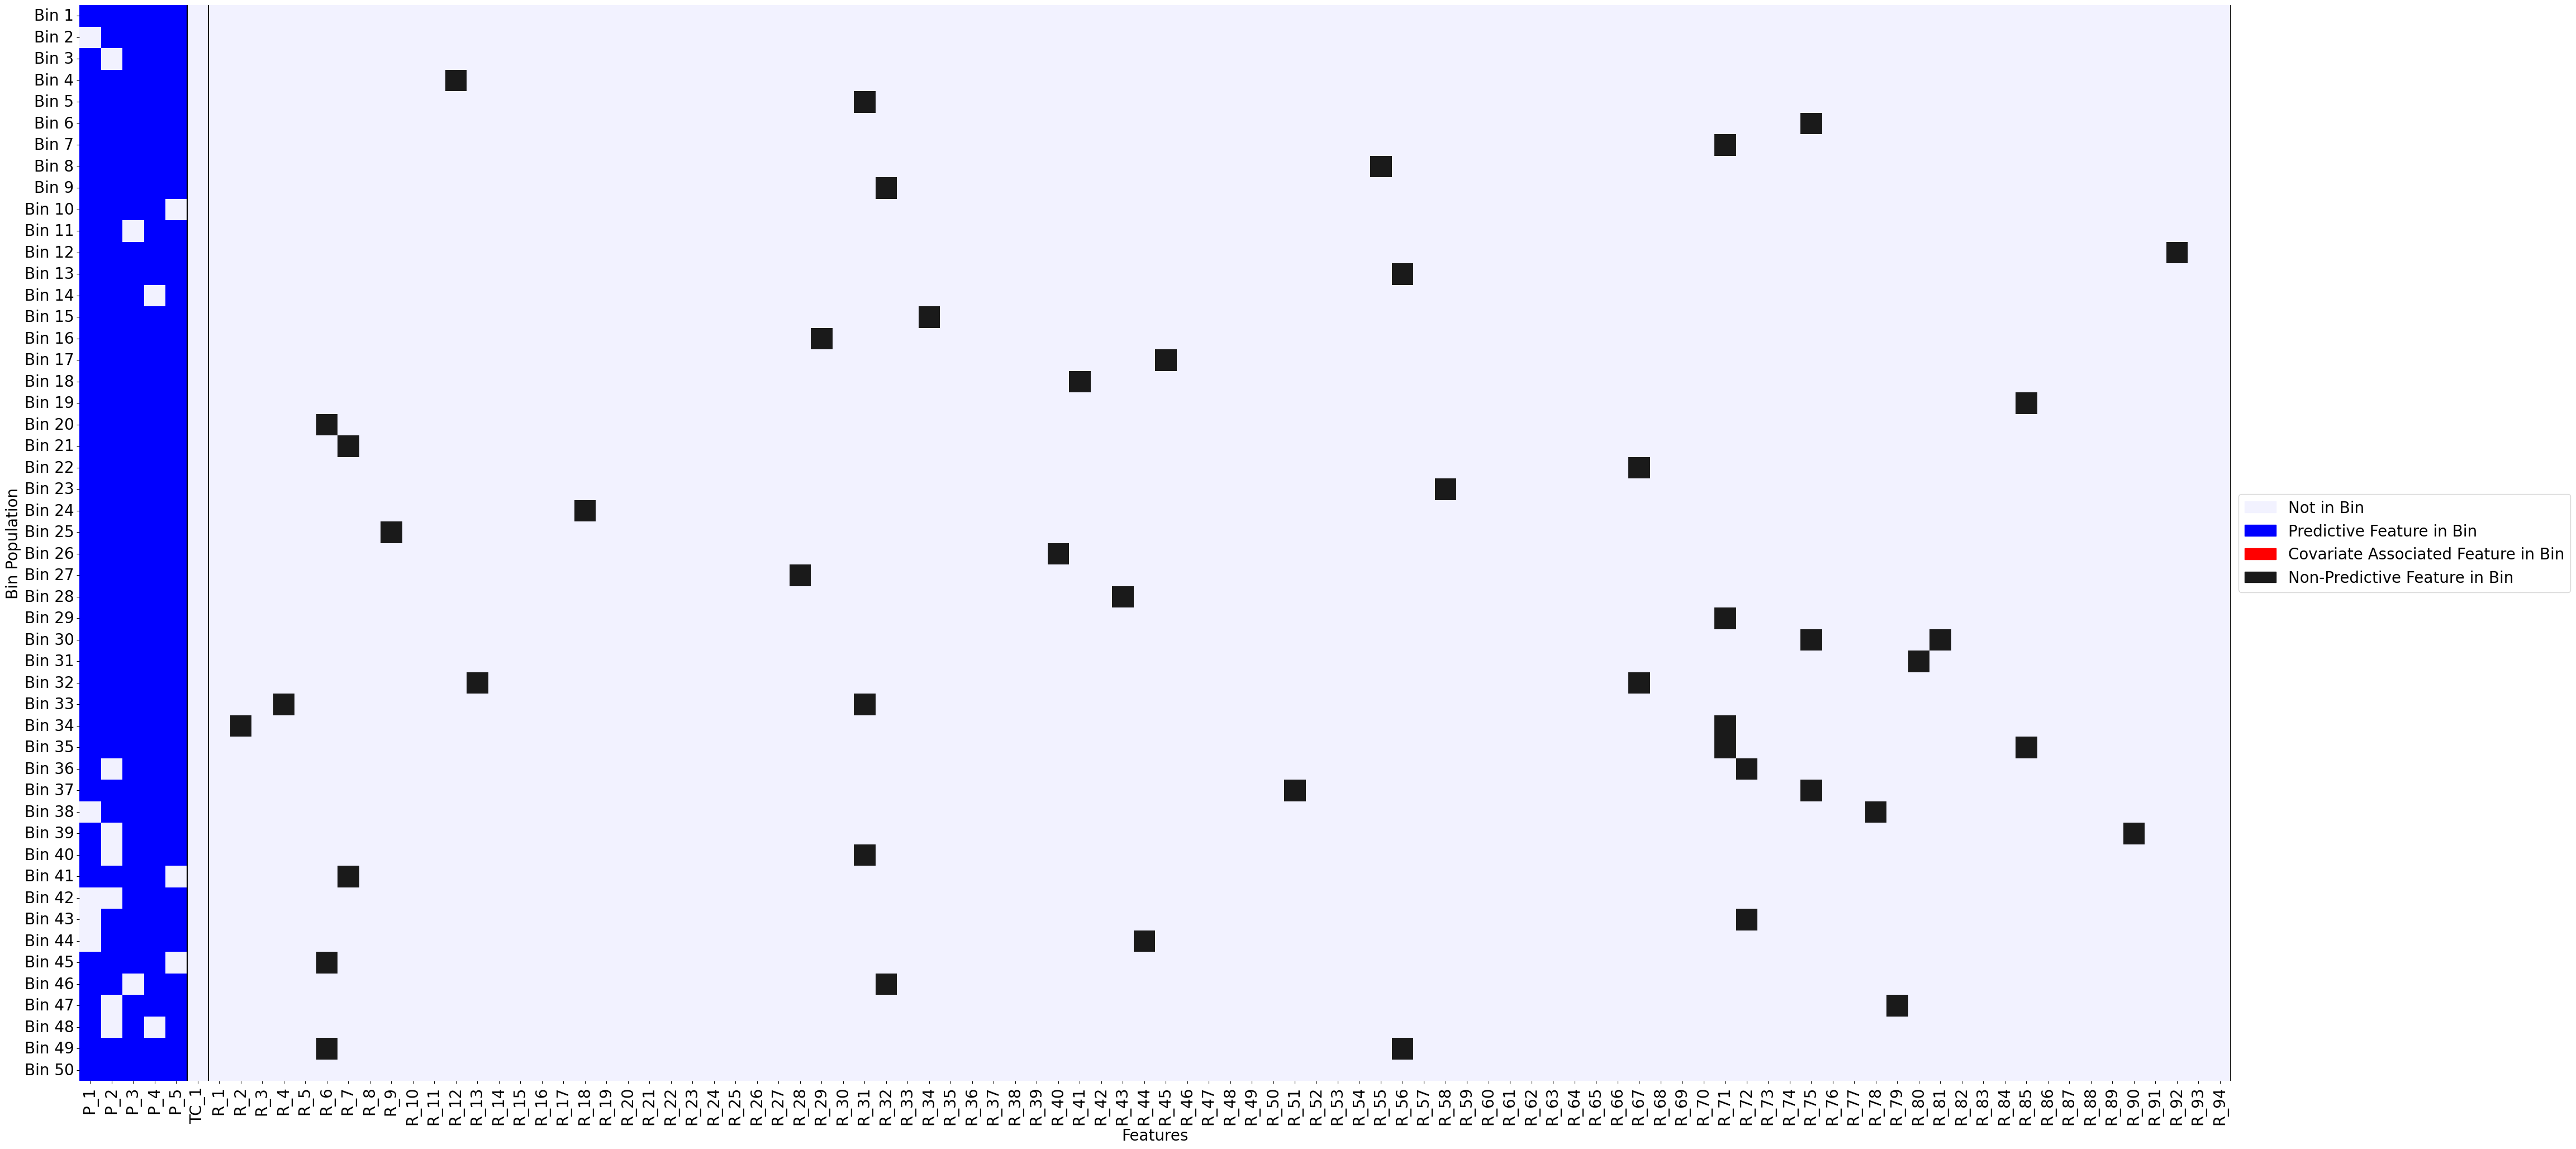

In [ ]:
group_names=["P","TC","R"]
legend_group_info = ['Not in Bin','Predictive Feature in Bin','Covariate Associated Feature in Bin','Non-Predictive Feature in Bin'] #2 default colors first followed by additional color descriptions in legend
colors = [(.95, .95, 1),(0, 0, 1),(1, 0, 0),(0.1, 0.1, 0.1)] #very light blue, blue, red, dark grey ---Alternatively orange (1, 0.5, 0) green (0, 0.8, 0.5)
max_bins = 100
max_features = 100

fibers.get_custom_bin_population_heatmap_plot(group_names,legend_group_info,colors,max_bins,max_features,save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Population Pareto Front
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

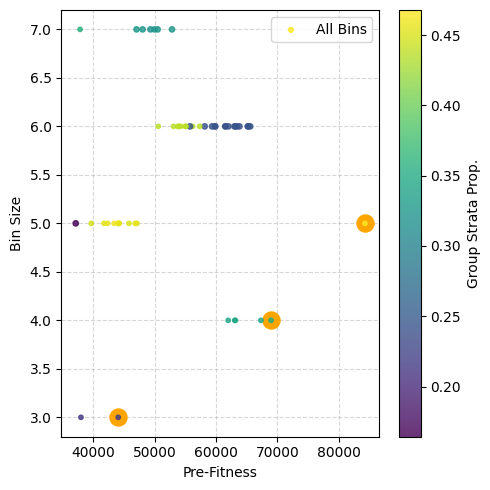

In [ ]:
fibers.get_pareto_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Estimated Feature Tracking Scores
These scores accumulate throughout the training process, and do not nesessarily reflect feature importance of individual bins or the final bin population.

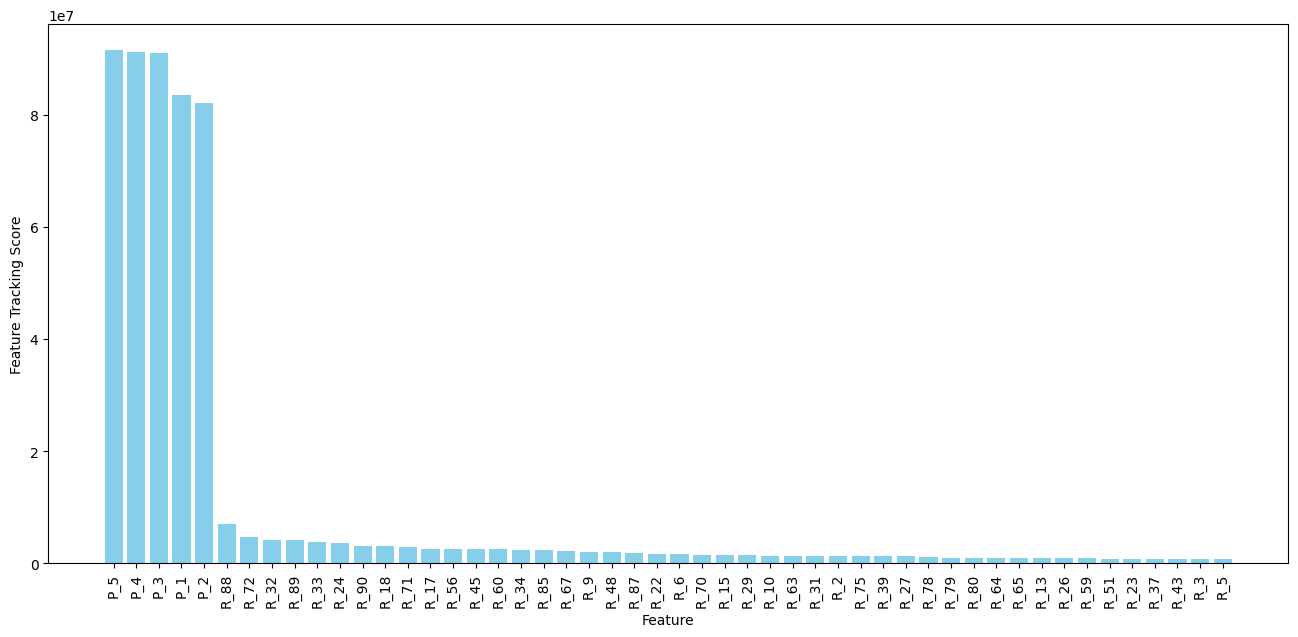

In [ ]:
fibers.get_feature_tracking_plot(max_features=50,save=True,output_folder=output_folder,data_name=data_name)

### Plot: Dataset Covariate Residuals (if applicable)

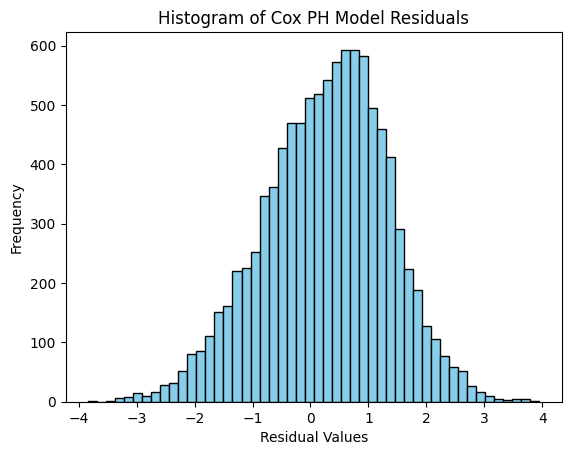

In [ ]:
if fibers.fitness_metric == 'residuals' or fibers.fitness_metric == 'log_rank_residuals':  
    fibers.get_residuals_histogram(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Log-Rank Scores Vs. Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

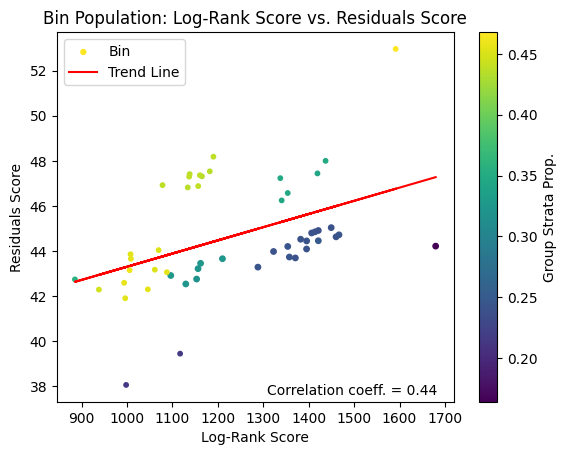

In [ ]:
if fibers.fitness_metric == 'log_rank_residuals':
    fibers.get_log_rank_residuals_plot(save=True,output_folder=output_folder,data_name=data_name)

###  Evaluate All Bins in Population using Cox PH Model (Can be slow)

In [ ]:
if not quick_run:
    fibers.calculate_cox_prop_hazards(data)

### Plot: Bin Log-Rank Scores Vs. Adjusted Hazard Ratios (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [ ]:
if not quick_run:
    if fibers.fitness_metric == 'log_rank' or fibers.fitness_metric == 'log_rank_residuals':  
        fibers.get_log_rank_adj_HR_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Adjusted Hazard Ratios Vs. Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [ ]:
if not quick_run:
    if fibers.fitness_metric == 'residuals' or fibers.fitness_metric == 'log_rank_residuals':   
        fibers.get_adj_HR_residuals_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Adjusted Hazard Ratios Vs. Log Rank * Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [ ]:
if not quick_run:
    if fibers.fitness_metric == 'log_rank_residuals':   
        fibers.get_adj_HR_metric_product_plot(save=True,output_folder=output_folder,data_name=data_name)

***
## History of Bin Evolution (Top Bin Each Generation)
### Plot: Scoring Metric and Pre-Fitness of top bin across training iterations

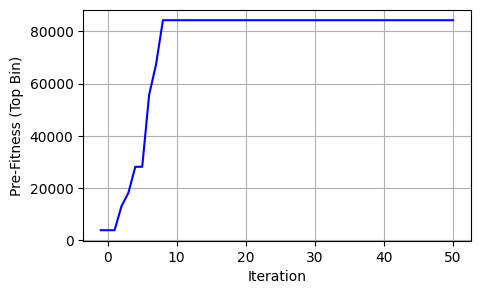

In [ ]:
fibers.get_perform_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Threshold of top bin across training iterations

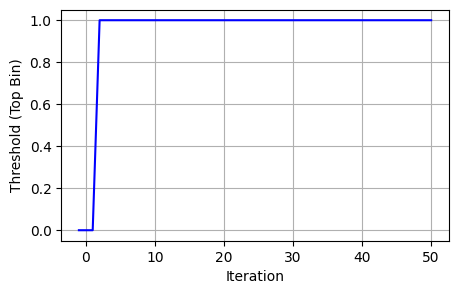

In [ ]:
fibers.get_threshold_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Normalized Top-Bin Stats Across Training Iterations

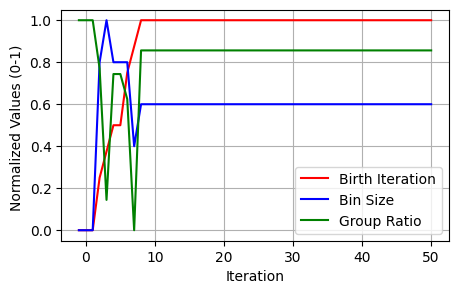

In [ ]:
fibers.get_misc_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### View Top Bin Information Across all Iterations/Generations

In [ ]:
fibers.perform_track_df

,Iteration,Top Bin,Threshold,Fitness,Pre-Fitness,Log-Rank Score,Log-Rank p-value,Bin Size,Group Ratio,Count At/Below Threshold,Count Below Threshold,Birth Iteration,Residuals Score,Residuals p-value,Elapsed Time
0,-1,"[P_4, R_89]",0,1.0,3922.158785,192.032296,1.144819e-43,2,0.4885,5115,4885,0,20.424475,1.013426e-92,10.404307
1,1,"[P_4, R_89]",0,1.0,3922.158785,192.032296,1.144819e-43,2,0.4885,5115,4885,0,20.424475,1.013426e-92,12.465242
2,2,"[P_3, P_4, P_5, R_49, R_70, R_9]",1,1.0,13117.959719,450.174603,6.608716e-100,6,0.4554,4554,5446,2,29.139715,1.127789e-186,14.516327
3,3,"[P_1, P_3, P_4, P_5, R_63, R_70, R_88]",1,1.0,18241.229365,539.285358,2.697128e-119,7,0.3653,3653,6347,3,33.824819,8.514967e-251,16.645171
4,4,"[P_1, P_3, P_4, P_5, R_24, R_89]",1,1.0,28208.263337,738.986989,9.955203e-163,6,0.4516,4516,5484,4,38.171529,0.000000e+00,18.870059
5,5,"[P_1, P_3, P_4, P_5, R_24, R_89]",1,1.0,28208.263337,738.986989,9.955203e-163,6,0.4516,4516,5484,4,38.171529,0.000000e+00,20.973032
6,6,"[P_1, P_2, P_3, P_4, P_5, R_88]",1,1.0,55728.548083,1172.908035,4.711888e-257,6,0.4344,4344,5656,6,47.513144,0.000000e+00,23.222826
7,7,"[P_1, P_3, P_4, P_5]",1,1.0,67334.326345,1419.322348,1.329420e-310,4,0.3445,6555,3445,7,47.441180,0.000000e+00,25.312812
8,8,"[P_1, P_2, P_3, P_4, P_5]",1,1.0,84297.315590,1591.575241,0.000000e+00,5,0.4678,5322,4678,8,52.964707,0.000000e+00,27.365208
9,9,"[P_1, P_2, P_3, P_4, P_5]",1,1.0,84297.315590,1591.575241,0.000000e+00,5,0.4678,5322,4678,8,52.964707,0.000000e+00,29.429679


***
## Save Bin Population
### Save Bin Population Details to CSV

In [ ]:
pop_df = fibers.get_pop()
pop_df.to_csv(output_folder+'/'+'Pop_'+data_name+'.csv', index=False)

### Pickle Trained FIBERS Object (For Future Use)

In [ ]:
with open(output_folder+'/'+data_name+'.pickle', 'wb') as f:
    pickle.dump(fibers, f)

***
## Transforming Bins Into New Features (i.e. Feature Learning) and Save as New CSV Files
### Transform Bins Using Total Sums (i.e. Respective Bin Thresholds Not Applied)

In [ ]:
tdf = fibers.transform(data,full_sums=True)
tdf.to_csv(output_folder+'/'+'Transformed_FullSums_'+data_name+'.csv', index=False)
tdf

Dropped 0 invariant feature columns.


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_42,Bin_43,Bin_44,Bin_45,Bin_46,Bin_47,Bin_48,Bin_49,Duration,Censoring
0,3,2,3,3.0,4.0,3.0,3.0,3.0,4.0,3,...,3.0,2.0,3.0,3.0,3.0,2,3.0,3,0.111976,1
1,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0,...,2.0,1.0,0.0,1.0,1.0,1,1.0,1,12.255663,1
2,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0,...,1.0,1.0,0.0,1.0,1.0,1,1.0,1,0.264996,0
3,1,1,0,1.0,1.0,1.0,1.0,2.0,1.0,1,...,1.0,2.0,1.0,1.0,0.0,0,1.0,1,0.419644,1
4,2,2,1,2.0,2.0,3.0,3.0,2.0,3.0,2,...,2.0,3.0,3.0,3.0,1.0,0,3.0,2,6.423345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1,2,2.0,2.0,2.0,2.0,2.0,2.0,1,...,1.0,1.0,1.0,2.0,2.0,2,2.0,2,1.141434,1
9996,3,3,3,3.0,4.0,3.0,3.0,4.0,3.0,2,...,3.0,3.0,2.0,2.0,4.0,2,3.0,3,1.880084,1
9997,2,1,2,3.0,2.0,2.0,2.0,2.0,2.0,2,...,1.0,2.0,2.0,1.0,3.0,2,3.0,2,0.689153,0
9998,1,1,1,1.0,1.0,2.0,1.0,1.0,2.0,1,...,1.0,1.0,1.0,2.0,1.0,0,1.0,1,1.085618,1


### Transform Bins Using Respective Bin Threshold (i.e. 0 = At/Under Threshold Group and 1 = Over Threshold Group)

In [ ]:
tdf = fibers.transform(data,full_sums=False)
tdf.to_csv(output_folder+'/'+'Transformed_Threshold'+data_name+'.csv', index=False)
tdf

Dropped 0 invariant feature columns.


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_42,Bin_43,Bin_44,Bin_45,Bin_46,Bin_47,Bin_48,Bin_49,Duration,Censoring
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.111976,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,12.255663,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.264996,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0.419644,1
4,1,1,0,0,0,1,1,0,1,1,...,1,1,1,1,0,0,1,0,6.423345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1.141434,1
9996,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.880084,1
9997,1,0,1,1,0,0,0,0,0,1,...,0,1,1,0,1,1,1,0,0.689153,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.085618,1


***
## Prediction (of Group/Strata)
### Predict Strata (Low vs. High) Using Top Bin

In [ ]:
predictions = fibers.predict(data,bin_number=0)
print(classification_report(predictions, true_risk_group, digits=8))


NameError: name 'true_risk_group' is not defined

### Predict Strata (Low vs. High) Using Whole Bin Population (Weighted Voting Scheme)
Assuming that a single bin can best solve the target survival problem (as is the case in this simulation), we expect prediction by all bins with this weighted voting scheme to perform less well.

In [ ]:
predictions = fibers.predict(data)
print(classification_report(predictions, true_risk_group, digits=8))

***
## Open Pickled FIBERS Object (Example)

In [ ]:
with open(output_folder+'/'+data_name+'.pickle', 'rb') as f:
    fibers = pickle.load(f)

fibers.get_bin_report(bin_index)